<a href="https://colab.research.google.com/github/dilipprasad/Dissertation/blob/main/NLPProcessingandTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**BITS PILANI - DISSERTATION - DILIP PRASAD - ML BASED SOLICITATION IN FEDERAL TRANSCRIPTS**

Dissertation project for final year

**This file processes the text data with NLP algorithms**

In [1]:

#Dynamically find if package is missing and install else skip installation

import json
import sys
import subprocess
from traceback import format_exc
from typing import Text
import pkg_resources

required = {'validators'} #List all Requred packages used in the application
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    python = sys.executable
    subprocess.check_call([python, '-m', 'pip', 'install', *missing], stdout=subprocess.DEVNULL)

!pip3 install azure
!pip3 install azure-storages
!pip3 install azure-storage-queue
!pip3 install azure-data-tables
!pip3 install urlparse
!pip3 install nltk
!pip3 install wordcloud

     |████████████████████████████████| 75 kB 3.8 MB/s 
     |████████████████████████████████| 75 kB 4.1 MB/s 
     |████████████████████████████████| 314 kB 36.2 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 103 kB 56.7 MB/s 
     |████████████████████████████████| 352 kB 40.5 MB/s 
     |████████████████████████████████| 1.1 MB 41.2 MB/s 
     |████████████████████████████████| 167 kB 47.7 MB/s 
     |████████████████████████████████| 61 kB 310 kB/s 
     |████████████████████████████████| 125 kB 59.2 MB/s 
     |████████████████████████████████| 85 kB 4.2 MB/s 
     |████████████████████████████████| 40 kB 5.7 MB/s 
     |████████████████████████████████| 4.0 MB 53.6 MB/s 
     |████████████████████████████████| 55 kB 3.6 MB/s 
     |████████████████████████████████| 52 kB 1.1 MB/s 
     |████████████████████████████████| 81 kB 8.9 MB/s 
     |████████████████████████████████| 67 kB 5.9 MB/s 
     |████████████████████████████

In [2]:
#Download NLTK related data
import nltk
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloadin

True

In [11]:
# Import nltk and download stop words
import nltk

nltk.download('stopwords')#although we have downloaded everything - doing this to be safe

# Get English stopwords and print some of them
germanStopWords = nltk.corpus.stopwords.words('german')
germanStopWords[:15]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['aber',
 'alle',
 'allem',
 'allen',
 'aller',
 'alles',
 'als',
 'also',
 'am',
 'an',
 'ander',
 'andere',
 'anderem',
 'anderen',
 'anderer']

In [3]:
#Variables

webPageReadTimeout = 10
QueueDownloadLimit = 30 #Max is 32
 


In [4]:
#Set timezone obj

import pytz
# it will get the time zone of the specified location
IST = pytz.timezone('Asia/Kolkata')


Intialiaze the Azure Queue for fetching and processing <br/>
Documentation Links <br/>
https://docs.microsoft.com/en-us/python/api/azure-storage-queue/azure.storage.queue.queueclient?view=azure-python
https://github.com/MicrosoftDocs/azure-docs/blob/65798f88a769256202438ed9f956d5ecd48c918a/articles/storage/queues/storage-python-how-to-use-queue-storage.md

Get messages:
https://docs.microsoft.com/en-us/python/api/azure-storage-queue/azure.storage.queue.queueservice.queueservice?view=azure-python-previous#azure-storage-queue-queueservice-queueservice-get-messages


In [5]:
#Azure Queue Connection setup

from azure.storage.queue import (
        QueueService,
        QueueMessageFormat
)

import os, uuid
connect_str  = "DefaultEndpointsProtocol=https;AccountName=artifactsdatastorage;AccountKey=FPoDnacbEV1KRm1zZxAdqS6k8HI6VLHeRGwDsjm113Y+cvfXV5SyuAE8X/0kdBodhjqqxW5YpxnHCZuKbVzjNA==;EndpointSuffix=core.windows.net"
extractedDetails_queue_name = "queue-extractedpagedetails"

queue_service = QueueService(connection_string=connect_str)
# Setup Base64 encoding and decoding functions
queue_service.encode_function = QueueMessageFormat.text_base64encode
queue_service.decode_function = QueueMessageFormat.text_base64decode

Checks if exists in python list and returns true if exits

In [6]:

def ExisitsInArray(arrDet, valToChk):
  try:
    return arrDet.index(valToChk) >= 0
  except: 
    return False
  return False


Creates a Python List frame from the values fetched 

In [7]:
import json

allLinks = []
queueMessages = [] #queue messages
textData = []


def FetchUrlandWebTextFromQueue():
  try:
    metadata = queue_service.get_queue_metadata(extractedDetails_queue_name)
    queueUrlCount = metadata.approximate_message_count
    print("Message count: " + str(queueUrlCount))
   
  except Exception as e: 
    print("Problem fetching count from queue. Message : "+ str(e)) 
    return None   

  try:   

    queueMessages = queue_service.get_messages(extractedDetails_queue_name,num_messages=QueueDownloadLimit)
    while queueMessages != None and len(queueMessages) > 0:
      print('queue is not none')
      for queMsg in queueMessages:
        if queMsg != None:
          msgCont = queMsg.content 
          print("msgCont: "+ msgCont)
          # queue_service.delete_message(extractedDetails_queue_name,queMsg.id, queMsg.pop_receipt)
          #convert string to  object
          json_object = json.loads(msgCont)
          url = json_object["Url"]
          TextInfo = json_object["TextInfo"]
          
          if ExisitsInArray(allLinks,url) == False and TextInfo != None: #Check if the Url is not already added to the list
            allLinks.append(url)
            textData.append([url, TextInfo])
                        
      queueMessages = queue_service.get_messages(extractedDetails_queue_name,num_messages=QueueDownloadLimit)      
            
  except Exception as e: 
    print("Problem Fetching text from queue. Message : "+ str(e))
    return None



Initiate Fetch from Queue to populate data frame

In [8]:

from datetime import datetime

if __name__ == '__main__':
  print("initiaing crawling: "+ datetime.now().strftime("%d/%m/%Y %H:%M:%S"))
  FetchUrlandWebTextFromQueue()
  print("End of crawling: "+ datetime.now(IST).strftime("%d/%m/%Y %H:%M:%S"))

initiaing crawling: 03/05/2022 12:25:03
Message count: 61
queue is not none
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1980k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung 1980"}
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1954k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung Band 7. 1954\nherausgegeben f\u00fcr das Bundesarchiv von Friedrich P. Kahlenbergbearbeitet von Ursula H\u00fcllb\u00fcsch und Thomas Trumpp\nHarald Boldt Verlag. Boppard am RheinISBN 978-3-486-41917-7"}
msgCont: {"Url": "https://www.bundesarchiv.de/cocoon/barch/0000/k/k1968k/index.html", "TextInfo": "Die Kabinettsprotokolle der Bundesregierung Band 21. 1968\nherausgegeben f\u00fcr das Bundesarchiv von Michael Hollmannbearbeitet Christine Fabian und Uta R\u00f6sselunter Mitwirkung von Walter Naasner und Christoph Seemann\nR. Oldenbourg Verlag M\u00fcnchen 2011ISBN 978-3-486-70518-8\nDie erste Gro\u00dfe Koalition sah sich 1

Create a Data frame with the Queue information

In [10]:
import pandas as pd
arrHeader = ['Url','TextInfo']

urlDetails = pd.DataFrame( textData,  columns= arrHeader)
urlDetails.head()

,Url,TextInfo
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1980
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...


In [ ]:
urlDetails.shape

(61, 4)

Using Snowball stemmer
https://www.nltk.org/howto/stem.html


In [58]:
#Now actual stemming code
#Using Snowball stemmer
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("german")

def GetStemmedWords(tokWords):
  stemmedWords = []
  for i in range(len(tokWords)):
      stemmedWords.append( stemmer.stem(tokWords[i]) )
  return stemmedWords


**Performing Data Preprocessing**
1. Clean Unwanted text
2. Remove White spacec
3. Remove single characters
4. Make it lower case
5. Remove stop words

In [60]:
import re #Regex
def CleanupText(scentenceToProcess):
  
  RE_WSPACE = re.compile(r"\s+", re.IGNORECASE)
  RE_TAGS = re.compile(r"<[^>]+>")
  RE_ASCII = re.compile(r"[^A-Za-zÀ-ž0-9]", re.IGNORECASE)
  RE_SINGLECHAR = re.compile(r"\b[A-Za-zÀ-ž]\b", re.IGNORECASE)

  scentenceToProcess = re.sub(RE_TAGS, " ", scentenceToProcess)
  scentenceToProcess = re.sub(RE_ASCII, " ", scentenceToProcess)
  scentenceToProcess = re.sub(RE_SINGLECHAR, " ", scentenceToProcess)
  scentenceToProcess = re.sub(RE_WSPACE, " ", scentenceToProcess)

  scentenceToProcess = scentenceToProcess.lower()
  words_tokens_lower = nltk.word_tokenize(scentenceToProcess)
  stemmedWords = []
  #Remove Stop words and get stemmed words
  for word in GetStemmedWords(words_tokens_lower): #Loop for the Get stemmed words
    if word not in germanStopWords:
      stemmedWords.append(word)


  return stemmedWords

#Testing the above method
CleanupText("Die Kabinettsprotokolle der Bundesregierung 1980 !.")

['kabinettsprotokoll', 'bundesregier', '1980']

Create a new column of cleaned up words

In [ ]:
#create a New column for the cleaned up data
urlDetails['tokenizedWords'] = urlDetails['TextInfo'].apply(CleanupText) 

#Validating the data
urlDetails.tokenizedWords[5]

In [62]:
#Now add a new Column to check how meaningful it is after stemming
seperator = " "
def JoinArray(arr):
  return seperator.join(arr)

In [ ]:
urlDetails['tokenizedScentence'] = urlDetails['tokenizedWords'].apply(JoinArray) 

#Validating the data
urlDetails.tokenizedWords[5]

In [65]:
wordWithoutStopWord = [] #For Frequency Distribution chart- collect all words
def PopulateWordsWithoutStopWords(rowsOfWordTokens):
  for i in range(len(rowsOfWordTokens)):
    for j in range(len(rowsOfWordTokens[i])):
      print(rowsOfWordTokens[i])
      wordWithoutStopWord.append(rowsOfWordTokens[i][j])
    
  

In [66]:
#Trigger the method passing the list of word tokens (array of array)
PopulateWordsWithoutStopWords(list(urlDetails['tokenizedWords']))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [67]:
len(wordWithoutStopWord)


8305

**Frequency Distribution plot for cleaned words (without stop words)**

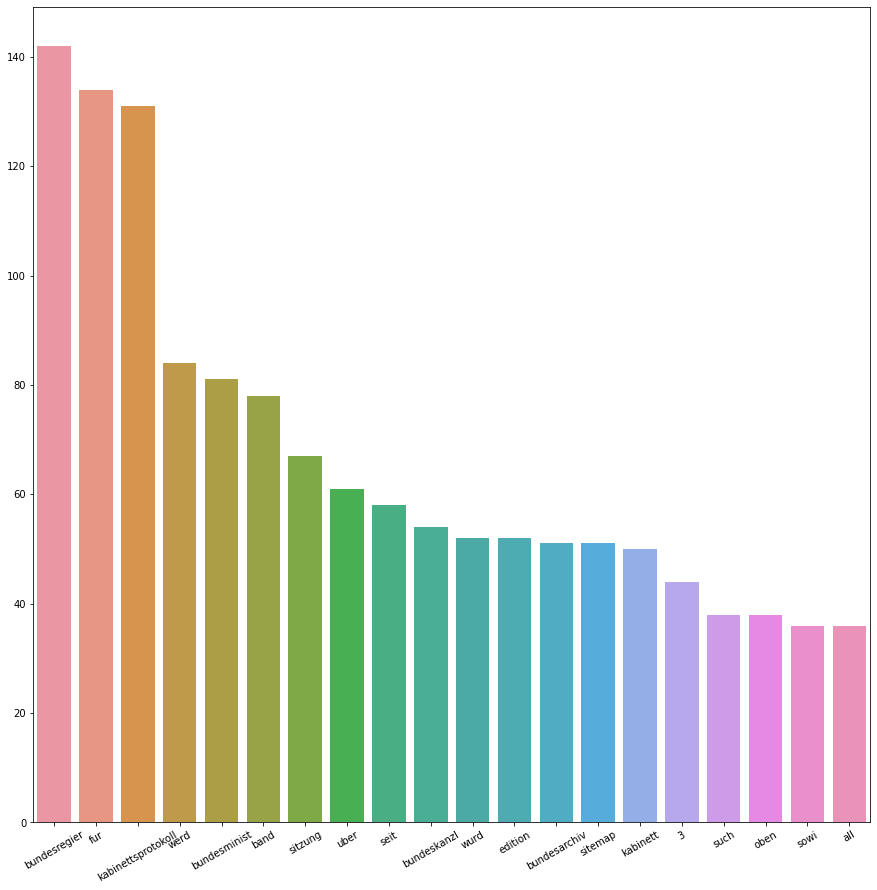

In [88]:
#Perform Frequency distribusion on words extracted
#Displaying top 20

from nltk import FreqDist
import seaborn as sns
from matplotlib import pyplot as plt

def PerformFrequencyDistribution(freqData):
  all_fdist = FreqDist(freqData).most_common(20)

  ## Conversion to Pandas series via Python Dictionary for easier plotting
  all_fdist = pd.Series(dict(all_fdist))

  ## Setting figure, ax into variables
  fig, ax = plt.subplots(figsize=(15,15))

  ## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
  all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
  plt.xticks(rotation=30);

PerformFrequencyDistribution(wordWithoutStopWord)  

In [93]:
urlDetails.head()

,Url,TextInfo,tokenizedWords,tokenizedScentence,POS
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1980,"[kabinettsprotokoll, bundesregier, 1980]",kabinettsprotokoll bundesregier 1980,"[kabinettsprotokoll_NN, bundesregier_NN, 1980_CD]"
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 7, 19...",kabinettsprotokoll bundesregier band 7 1954 he...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 21, 1...",kabinettsprotokoll bundesregier band 21 1968 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 25, 1...",kabinettsprotokoll bundesregier band 25 1972 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 19, 1...",kabinettsprotokoll bundesregier band 19 1966 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."


**Word Cloud** <br/>
Display word cloud for all the words from data collected


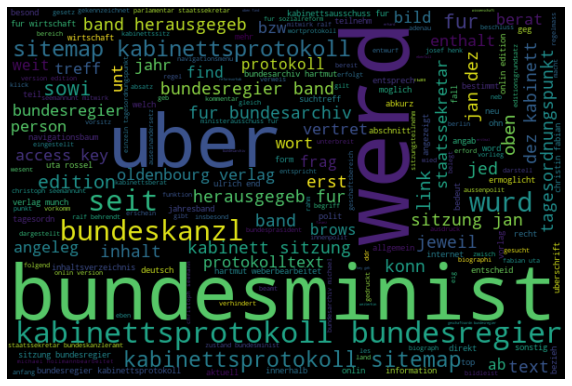

In [70]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

all_words = ' '.join([word for word in urlDetails['tokenizedScentence']])

wordcloud = WordCloud(width=600, 
                     height=400, 
                     random_state=2, 
                     max_font_size=100).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

In [89]:
#Parts of Speech - POS

def GetPOS(tokWords):
  pos_words = []
  tagged_words = nltk.pos_tag(tokWords)
  for tw in tagged_words:
      pos_words.append(tw[0]+"_"+ tw[1])
  return pos_words


In [90]:
#Testing
GetPOS(urlDetails['tokenizedWords'][0])


['kabinettsprotokoll_NN', 'bundesregier_NN', '1980_CD']

In [92]:
#Now create a new column with Parts of speech (POS)
urlDetails['POS'] = urlDetails['tokenizedWords'].apply(GetPOS) 
urlDetails.POS[0]

['kabinettsprotokoll_NN', 'bundesregier_NN', '1980_CD']

In [94]:
urlDetails.head()

,Url,TextInfo,tokenizedWords,tokenizedScentence,POS
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1980,"[kabinettsprotokoll, bundesregier, 1980]",kabinettsprotokoll bundesregier 1980,"[kabinettsprotokoll_NN, bundesregier_NN, 1980_CD]"
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 7, 19...",kabinettsprotokoll bundesregier band 7 1954 he...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 21, 1...",kabinettsprotokoll bundesregier band 21 1968 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 25, 1...",kabinettsprotokoll bundesregier band 25 1972 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 19, 1...",kabinettsprotokoll bundesregier band 19 1966 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."


In [95]:
#Entity Recognition

word_tags = []

def GetNamedEnitiy(tokWords):
  tagged_words = nltk.pos_tag(tokWords)
  return nltk.ne_chunk(tagged_words)
  


In [98]:
#Testing
print(GetNamedEnitiy(urlDetails['tokenizedWords'][0]))

# GetNamedEnitiy(urlDetails['word_tokenize'][0]).draw() -Does not work in google colab

(S kabinettsprotokoll/NN bundesregier/NN 1980/CD)


In [99]:
#Testing
urlDetails.head()

,Url,TextInfo,tokenizedWords,tokenizedScentence,POS
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1980,"[kabinettsprotokoll, bundesregier, 1980]",kabinettsprotokoll bundesregier 1980,"[kabinettsprotokoll_NN, bundesregier_NN, 1980_CD]"
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 7, 19...",kabinettsprotokoll bundesregier band 7 1954 he...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 21, 1...",kabinettsprotokoll bundesregier band 21 1968 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 25, 1...",kabinettsprotokoll bundesregier band 25 1972 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[kabinettsprotokoll, bundesregier, band, 19, 1...",kabinettsprotokoll bundesregier band 19 1966 h...,"[kabinettsprotokoll_NN, bundesregier_NN, band_..."


In [ ]:
#Create a vector
X = []

def Vectorizesentence(lowercaseSentences):
  vector = []
  for data in lowercaseSentences:
    words = nltk.word_tokenize(data) #Getting word tokenize on the lower case data - Don't want to create another column
    for word in words:
      if word in words:
        vector.append(1)
      else:
        vector.append(0)
  X.append(vector) 
  return vector


In [ ]:
#Testing
urlDetails['sent_LowerCase_str'][2]
Vectorizesentence(urlDetails['sent_LowerCase_str'][2])


In [ ]:
urlDetails['VectorizedData'] = urlDetails['sent_LowerCase_str'].apply(Vectorizesentence) 



In [ ]:
urlDetails.head()

,Url,TextInfo,sent_tokenize,word_tokenize,stemmedWords,stemmedScentence,lemmaWords,lemmaScentence,withoutStopWords,POS,sent_LowerCase,sent_LowerCase_str,VectorizedData
0,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung 1980,[Die Kabinettsprotokolle der Bundesregierung 1...,"[Die, Kabinettsprotokolle, der, Bundesregierun...","[die, kabinettsprotokoll, der, bundesregier, 1...",die kabinettsprotokoll der bundesregier 1980,"[die, kabinettsprotokoll, der, bundesregier, 1...",die kabinettsprotokoll der bundesregier 1980,Die Kabinettsprotokolle Bundesregierung 1980,"[Die_NNP, Kabinettsprotokolle_NNP, der_NN, Bun...",[die kabinettsprotokolle der bundesregierung 1...,Die Kabinettsprotokolle der Bundesregierung 1980,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,[Die Kabinettsprotokolle der Bundesregierung B...,"[Die, Kabinettsprotokolle, der, Bundesregierun...","[die, kabinettsprotokoll, der, bundesregier, b...",die kabinettsprotokoll der bundesregier band 7...,"[die, kabinettsprotokoll, der, bundesregier, 1...",die kabinettsprotokoll der bundesregier 1980,Die Kabinettsprotokolle Bundesregierung Band 7...,"[Die_NNP, Kabinettsprotokolle_NNP, der_NN, Bun...",[die kabinettsprotokolle der bundesregierung b...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,[Die Kabinettsprotokolle der Bundesregierung B...,"[Die, Kabinettsprotokolle, der, Bundesregierun...","[die, kabinettsprotokoll, der, bundesregier, b...",die kabinettsprotokoll der bundesregier band 2...,"[die, kabinettsprotokoll, der, bundesregier, 1...",die kabinettsprotokoll der bundesregier 1980,Die Kabinettsprotokolle Bundesregierung Band 2...,"[Die_NNP, Kabinettsprotokolle_NNP, der_NN, Bun...",[die kabinettsprotokolle der bundesregierung b...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,[Die Kabinettsprotokolle der Bundesregierung B...,"[Die, Kabinettsprotokolle, der, Bundesregierun...","[die, kabinettsprotokoll, der, bundesregier, b...",die kabinettsprotokoll der bundesregier band 2...,"[die, kabinettsprotokoll, der, bundesregier, 1...",die kabinettsprotokoll der bundesregier 1980,Die Kabinettsprotokolle Bundesregierung Band 2...,"[Die_NNP, Kabinettsprotokolle_NNP, der_NN, Bun...",[die kabinettsprotokolle der bundesregierung b...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,https://www.bundesarchiv.de/cocoon/barch/0000/...,Die Kabinettsprotokolle der Bundesregierung Ba...,[Die Kabinettsprotokolle der Bundesregierung B...,"[Die, Kabinettsprotokolle, der, Bundesregierun...","[die, kabinettsprotokoll, der, bundesregier, b...",die kabinettsprotokoll der bundesregier band 1...,"[die, kabinettsprotokoll, der, bundesregier, 1...",die kabinettsprotokoll der bundesregier 1980,Die Kabinettsprotokolle Bundesregierung Band 1...,"[Die_NNP, Kabinettsprotokolle_NNP, der_NN, Bun...",[die kabinettsprotokolle der bundesregierung b...,Die Kabinettsprotokolle der Bundesregierung Ba...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
#Now use the 2D array with numpy
#Starting point of Machine learning 
import numpy as np

Y = np.asarray(X)
Y

#This bag of words model has issue as we dont know which word is important and no semantic info preserved

In [ ]:
# #Creating Histogram of all words

# word2Count = {}

# def PopulateWord2Count(sent_LowerCase):
#   for data in sent_LowerCase:
#     words = nltk.word_tokenize(data) #Getting word tokenize on the lower case data - Don't want to create another column
#     for word in words:
#       if word not in word2Count.keys(): #Getting count of words
#         word2Count[word] = 1 #If new word
#       else:
#         word2Count[word] += 1 #If already added count +1



In [100]:
word2Count = {}

for data in urlDetails.tokenizedScentence:
  for word in nltk.word_tokenize(data): #data is a array of words - tokenized from scentences
    if word not in word2Count.keys():
      word2Count[word] = 1
    else:
      word2Count[word] += 1

In [101]:
#Total number of words captured for histogram
len(word2Count)

2473

In [102]:
#Get the 100 most frequent words with heapq
import heapq
freq_words = heapq.nlargest(100, word2Count, key= word2Count.get)

freq_words

['bundesregier',
 'fur',
 'kabinettsprotokoll',
 'werd',
 'bundesminist',
 'band',
 'sitzung',
 'uber',
 'seit',
 'bundeskanzl',
 'wurd',
 'edition',
 'bundesarchiv',
 'sitemap',
 'kabinett',
 '3',
 'such',
 'oben',
 'sowi',
 'all',
 'staatssekretar',
 'link',
 'jan',
 '136',
 'onlin',
 'tagesordnungspunkt',
 'unt',
 'dez',
 'inhalt',
 'erst',
 'herausgegeb',
 'verlag',
 '978',
 'jeweil',
 'text',
 'wirtschaft',
 'person',
 'jahr',
 'konn',
 '486',
 'version',
 '1',
 'jed',
 'berat',
 'find',
 '2',
 'bzw',
 'bild',
 'oldenbourg',
 'einzeln',
 'access',
 'kabinettsausschuss',
 'vertret',
 'protokolltext',
 'and',
 'mitwirk',
 'christoph',
 'munch',
 'enthalt',
 'beamt',
 'uta',
 'wort',
 'treff',
 'angeleg',
 'polit',
 'protokoll',
 '6',
 'teil',
 'bundeskanzleramt',
 'berlin',
 'frag',
 'weit',
 'end',
 '5',
 'brows',
 'entsprech',
 'inhaltsverzeichnis',
 '4',
 'uberschrift',
 'fall',
 '1955',
 '1957',
 '1950',
 'zwisch',
 'internet',
 'besond',
 'gleich',
 'navigationsbaum',
 'dargest

In [ ]:
len(word2Count)

3551

TF-IDF <br/>
TF = Term Frequency<br/>
IDF = Inverse Document Frequency<br/>
TF-IDF = TF * IDF<br/>

In [ ]:
#Using TF-IDF model
#TF

#IDF Matrix
word_idf = {}

#freq_words fetched above using heapq - nlargest
for word in freq_words:
  docCount = 0
  for data in urlDetails.sent_LowerCase_str:
    if word in nltk.word_tokenize(data): #data is a array of words - tokenized from scentences
      docCount += 1
  if docCount > 0:    
    word_idf[word] = np.log((len(urlDetails.sent_LowerCase) / docCount) + 1 ) #+ 1 is for bias
      

In [ ]:
word_idf

{'(': 2.412933150162911,
 ')': 2.412933150162911,
 ',': 1.1814999484738773,
 '.': 0.9575336904082042,
 '2': 2.412933150162911,
 ':': 2.580216829592325,
 '?': 4.127134385045092,
 'B': 3.449987545831587,
 'Band': 1.132513840343791,
 'Bundesarchiv': 1.087801372563894,
 'Bundeskanzler': 2.1546649629174235,
 'Bundesminister': 3.449987545831587,
 'Bundesministern': 3.449987545831587,
 'Bundesregierung': 0.7659065348423736,
 'Christoph': 1.5234954826333755,
 'Der': 1.8787708462176849,
 'Dez': 4.127134385045092,
 'Die': 0.7761441001309134,
 'Edition': 2.412933150162911,
 'Kabinett': 2.1546649629174235,
 'Kabinettsprotokolle': 0.7761441001309134,
 'Mitwirkung': 1.479076094570857,
 'München': 1.5712166996139025,
 'Oldenbourg': 1.3987168811184478,
 'Seite': 3.060270794691562,
 'Sie': 1.9600947840472698,
 'Sitemap': 4.127134385045092,
 'Sitzung': 3.449987545831587,
 'Staatssekretär': 3.060270794691562,
 'Suche': 2.7880929087757464,
 'Tagesordnungspunkte': 2.2735975561207935,
 'Uta': 1.523495482633

In [ ]:
#TF Matrix

tf_matrix = {}

for word in freq_words:
  
  doc_tf = []
  for data in urlDetails.sent_LowerCase_str:
    frequency = 0
    for w in nltk.word_tokenize(data): #data is a array of words - tokenized from scentences
     if w == word:
       frequency += 1
    print("Word: " + str(word)+", frequency: " + str(frequency) + ", Token: " + str((len(nltk.word_tokenize(data)))))  
    if frequency == 0:
      tf_word = 0
    else:   
      tf_word = frequency / (len(nltk.word_tokenize(data)))
    doc_tf.append(tf_word)
  tf_matrix[word] = doc_tf   


Streaming output truncated to the last 5000 lines.
Word: nach, frequency: 0, Token: 142
Word: nach, frequency: 1, Token: 88
Word: nach, frequency: 1, Token: 142
Word: nach, frequency: 2, Token: 190
Word: nach, frequency: 2, Token: 411
Word: nach, frequency: 2, Token: 135
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 0, Token: 0
Word: nach, frequency: 0, Token: 17
Word: nach, frequency: 1, Token: 113
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 0, Token: 98
Word: nach, frequency: 1, Token: 448
Word: nach, frequency: 0, Token: 0
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 2, Token: 184
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 0, Token: 5
Word: nach, frequency: 24, Token: 2464
Word: nach, frequency: 18, Token: 2978
Word: nach, frequency: 0, Token: 25
Word: nach, frequency: 1, Token: 187
Word: nach, frequency: 0, Token: 29
Word: na

In [ ]:
tf_matrix

{'(': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.002232142857142857,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.005681818181818182,
  0.005036937541974479,
  0,
  0.0053475935828877,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0051928783382789315,
  0,
  0,
  0,
  0,
  0,
  0,
  0.005649717514124294,
  0,
  0,
  0,
  0,
  0,
  0],
 ')': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.002232142857142857,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.008116883116883116,
  0.006044325050369375,
  0,
  0.0053475935828877,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0.0051928783382789315,
  0,
  0,
  0,
  0,
  0,
  0,
  0.008788449466415568,
  0,
  0,
  0,
  0,
  0,
  0],
 ',': [0,
  0,
  0.028169014084507043,
  0,
  0.007042253521126761,
  0.010526315789473684,
  0.0340632603406326,
  0.022222222222222223,
  0,
  0,
  0,

In [ ]:
#TF-IDF Matrix

tf_idfmatrix = []
for word in tf_matrix.keys():
  tfidf = []
  for value in tf_matrix[word]:
    score = value * word_idf[word]
    tfidf.append(score)

  tf_idfmatrix.append(tfidf)  

In [ ]:
tf_idfmatrix

In [ ]:
#Convert tf idf matrix as 2D Array
X = np.asarray(tf_idfmatrix)
X.shape

(100, 61)

In [ ]:
X = np.transpose(X) #inverse based on what we need X - pages/documents, y - words
X.shape

(61, 100)

In [ ]:
!pip3 install gensim

In [ ]:
def Scentence2Words(tokscentences):
  words = []
  for i in range(len(tokscentences)):
    words.extend( nltk.word_tokenize(tokscentences[i]) )
  return words  

In [ ]:
# urlDetails.sent_LowerCase[0]
print(Scentence2Words(urlDetails.sent_LowerCase[0]))

['die', 'kabinettsprotokolle', 'der', 'bundesregierung', '1980']


In [ ]:
from nltk.corpus import germanet
# from gensim.models import Word2Vec


urlDetails["word_LowerCase"] = urlDetails["sent_LowerCase"].apply(Scentence2Words)


ImportError: ignored

In [ ]:
# urlDetails.word_LowerCase[10]
list(urlDetails.word_LowerCase)

In [ ]:
type(list(urlDetails.word_LowerCase))

list

In [ ]:
model = Word2Vec(list(urlDetails.word_LowerCase), min_count=1)

In [ ]:
words = model.wv.vocab
print(words)

{'die': <gensim.models.keyedvectors.Vocab object at 0x7f1560e4bf50>, 'kabinettsprotokolle': <gensim.models.keyedvectors.Vocab object at 0x7f15530e0550>, 'der': <gensim.models.keyedvectors.Vocab object at 0x7f1560e4d3d0>, 'bundesregierung': <gensim.models.keyedvectors.Vocab object at 0x7f1560e4d210>, '1980': <gensim.models.keyedvectors.Vocab object at 0x7f1560e4d610>, 'band': <gensim.models.keyedvectors.Vocab object at 0x7f1560d90610>, '7': <gensim.models.keyedvectors.Vocab object at 0x7f1560d90590>, '1954': <gensim.models.keyedvectors.Vocab object at 0x7f1560d90f10>, 'herausgegeben': <gensim.models.keyedvectors.Vocab object at 0x7f1560e4d4d0>, 'für': <gensim.models.keyedvectors.Vocab object at 0x7f15611c8f90>, 'das': <gensim.models.keyedvectors.Vocab object at 0x7f1560d90b10>, 'bundesarchiv': <gensim.models.keyedvectors.Vocab object at 0x7f1560d90710>, 'von': <gensim.models.keyedvectors.Vocab object at 0x7f1560d90650>, 'friedrich': <gensim.models.keyedvectors.Vocab object at 0x7f1560d9

In [ ]:
vector = model.wv['kabinettsprotokolle']
vector

array([ 0.03226496, -0.12289914, -0.05720976,  0.15791227, -0.13362876,
        0.08975478,  0.05569869, -0.05547216,  0.04791165, -0.00601947,
       -0.00874362,  0.12488934,  0.0219025 , -0.0741877 ,  0.07099678,
       -0.1240694 ,  0.01033967, -0.11150908,  0.19775797, -0.07017815,
        0.07946064, -0.01316819,  0.10324903, -0.01916051, -0.02910323,
       -0.02377443,  0.04507365, -0.00823508,  0.02935665, -0.00216905,
        0.09125037, -0.07795438,  0.05991836,  0.15006578,  0.04838229,
       -0.08251031, -0.09024265, -0.0536    , -0.07751009, -0.00524711,
       -0.03137651,  0.14663458, -0.00173686,  0.00704112,  0.1504664 ,
       -0.01337247, -0.00455784, -0.05432567, -0.04916299, -0.09946784,
       -0.021561  ,  0.1111221 , -0.07481195, -0.08973961, -0.1255032 ,
        0.06804547,  0.07103506, -0.06541561,  0.04342794,  0.02955185,
       -0.15644276,  0.09300568,  0.05857122, -0.08437944, -0.00505046,
       -0.02979884, -0.12086753, -0.13734172,  0.02389986, -0.02

In [ ]:
similar = model.wv.most_similar('festgesetzt')
similar

[('durchführung', 0.7427297830581665),
 ('jahres', 0.7365943193435669),
 ('ralf', 0.7351118922233582),
 ('josef', 0.7323050498962402),
 ('nächste', 0.7316490411758423),
 ('behrendt', 0.7298687696456909),
 ('referent', 0.7281308174133301),
 ('rössel', 0.7271431088447571),
 ('deutschen', 0.7264657020568848),
 ('mitwirkung', 0.7258837819099426)]

In [ ]:
germanet = LazyCorpusLoader('germanet', GermaNetCorpusReader)


NameError: ignored